## Test data

In [ ]:
from datamodule_jetclass import JetSequence

tops = JetSequence(filepath='/home/df630/SyntheticJets/data/TTBar_val___1Mfromeach_403030.h5', )
qcd = JetSequence(filepath='/home/df630/SyntheticJets/data/ZJetsToNuNu_val___1Mfromeach_403030.h5', )

tops_seq = tops.map_to_sequence()
tops_bin = tops.seq_to_bins_decoding(tops_seq)
qcd_seq = qcd.map_to_sequence()
qcd_bin = qcd.seq_to_bins_decoding(qcd_seq)


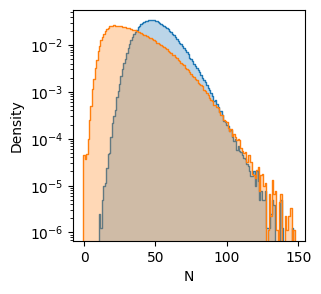

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, _ = plt.subplots(1, 1, figsize=(3, 3))
sns.histplot((tops_seq != tops.pad_token).sum(axis=1), discrete=True, fill=True, alpha=0.3, label='gpt2', element='step', stat='density',)
sns.histplot((qcd_seq != qcd.pad_token).sum(axis=1), discrete=True, fill=True, alpha=0.3, label='gpt2', element='step', stat='density',)

plt.xlabel('N')
plt.ylabel('Density')
plt.yscale('log')
plt.show()

## Generate jet sequences

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as L

from torch.utils.data import DataLoader
from models import JetGPT2Model

###############################################################################
N = 1_000  # num gen jets
sig_id = "e66587b2c59b4773a97aa4afabd9b095"        # comet run folder
bkg_id = "bfd0ed551863419a8a30e04b5a2fbae6"
path = "/home/df630/SyntheticJets/experiments/results/comet/tokenized-jets/"
###############################################################################

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pytorch_lightning.callbacks import Callback
from lightning.pytorch.utilities import rank_zero_only

class GeneratorCallback(Callback):
    def __init__(self, data_dir, file_name):
        super().__init__()
        
        self.data_dir = data_dir
        self.file_name = file_name

    def on_predict_start(self, trainer, pl_module):
        self.batched_seqs = []

    def on_predict_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        self.batched_seqs.append(outputs)

    def on_predict_end(self, trainer, pl_module):
        rank = trainer.global_rank

        self._save_results_local(rank)
        trainer.strategy.barrier()  # wait for all ranks to finish

        if trainer.is_global_zero:
            self._gather_results_global(trainer)
            self._clean_temp_files()

    ############
    ### helpers:
    ############

    def _save_results_local(self, rank):
        data = torch.cat(self.batched_seqs, dim=1)
        random = np.random.randint(0, 1000)
        path = f"{self.data_dir}/temp_data_{rank}_{random}.pt"
        torch.save(data, path)

    @rank_zero_only
    def _gather_results_global(self, trainer):
        temp_files = self.data_dir.glob("temp_data_*_*.pt")
        data_tokens = torch.cat([torch.load(str(f)) for f in temp_files], dim=1)
        np.save(f'{self.data_dir}/{self.file_name}_tokens.npy', data_tokens)

        Jets = JetSequence()
        data_binned = make_continuous(Jets.seq_to_bins_decoding(data_tokens))
        np.save(f'{self.data_dir}/{self.file_name}_binned.npy', data_binned)

    def _clean_temp_files(self):
        for f in self.data_dir.glob("temp_data_*_*.pt"):
            f.unlink()
        for f in self.data_dir.glob("temp_data_*_*.pt"):
            f.unlink()

In [3]:
#...Tops

tops_gpt2 = JetGPT2Model.load_from_checkpoint(f"{path}/{sig_id}/checkpoints/best.ckpt", map_location="cpu",)
tops_gpt2.top_k = 5000 #tops_gpt2.start_token # remove top_k default cut

prompts = torch.full((N, 1), tops_gpt2.start_token, dtype=torch.long)#, device=tops_gpt2.device)
prompt_dataloadeer = DataLoader(prompts, batch_size=1024, shuffle=False)

gen_callback = GeneratorCallback(data_dir=path, file_name='gen_tops_seq_gpt2_top5000')
generator = L.Trainer(accelerator="gpu", devices=[0,1,2,3], strategy='ddp_notebook', callbacks=[gen_callback])
tops_gen_seq = generator.predict(tops_gpt2, dataloaders=prompt_dataloadeer, ckpt_path=f"{path}/{sig_id}/checkpoints/best.ckpt")
# tops_gen_seq = torch.cat(tops_gen_seq, dim=0)

# np.save(f'{path}{sig_id}/gen_tops_seq_gpt2_top5000.npy', tops_gen_seq)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

Restoring states from the checkpoint path at /home/df630/SyntheticJets/experiments/results/comet/tokenized-jets//e66587b2c59b4773a97aa4afabd9b095/checkpoints/best.ckpt
W0511 11:27:10.378000 3947604 site-packages/torch/multiprocessing/spawn.py:160] Terminating process 3947691 via signal SIGTERM
W0511 11:27:10.383000 3947604 site-packages/torch/multiprocessing/spawn.py:160] T

ProcessExitedException: process 1 terminated with signal SIGSEGV

In [ ]:
#...QCD

qcd_gpt2 = JetGPT2Model.load_from_checkpoint(f"{path}/{bkg_id}/checkpoints/best.ckpt")
qcd_gpt2.top_k = 5000 #qcd_gpt2.start_token # remove top_k default cut

prompts = torch.full((N, 1), qcd_gpt2.start_token, dtype=torch.long, device=qcd_gpt2.device)
prompt_dataloadeer = DataLoader(prompts, batch_size=1024, shuffle=False)

generator = L.Trainer(accelerator="gpu", devices=[1])
qcd_gen_seq = generator.predict(qcd_gpt2, dataloaders=prompt_dataloadeer)
qcd_gen_seq = torch.cat(qcd_gen_seq, dim=0)
np.save(f'{path}{bkg_id}/gen_qcd_seq_gpt2_top5000.npy', qcd_gen_seq)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/df630/.conda/envs/markov_bridges/lib/python3.10/site-packages/pytorch_lightning-2.5.0.post0-py3.10.egg/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

## validation plots

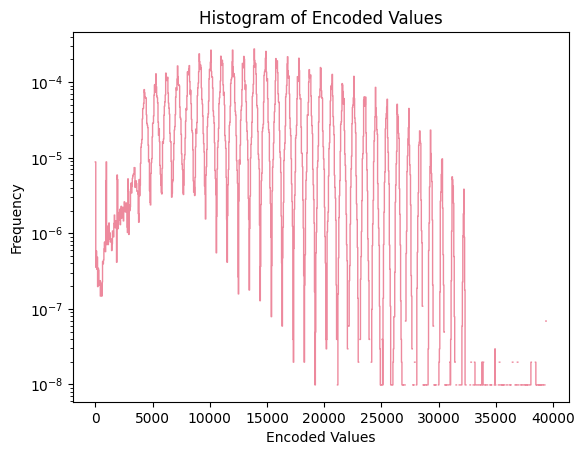

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(tops_gen_seq[tops_gen_seq>=0], lw=1,bins=1000, fill=False, alpha=0.5, label='sample', element='step', stat='density', color='crimson', log_scale=(False, True))
plt.xlabel('Encoded Values')
plt.ylabel('Frequency')
plt.title('Histogram of Encoded Values')
plt.show()

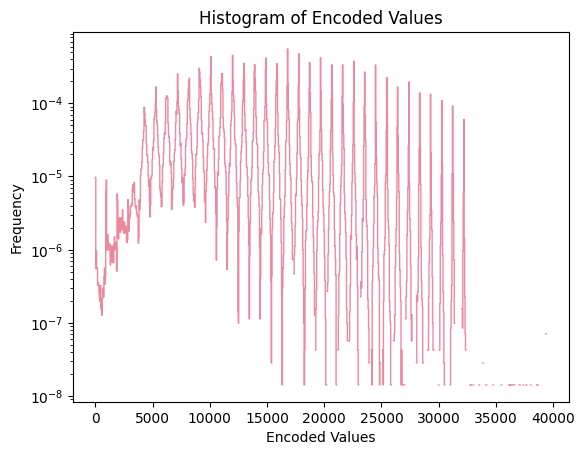

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(qcd_gen_seq[qcd_gen_seq>0], lw=1,bins=1000, fill=False, alpha=0.5, label='sample', element='step', stat='density', color='crimson', log_scale=(False, True))
plt.xlabel('Encoded Values')
plt.ylabel('Frequency')
plt.title('Histogram of Encoded Values')
plt.show()

## Binned jets

In [2]:
# open h5 file load

import h5py
import numpy as np
import pandas as pd

def load_h5_data(file_path, key):
    with h5py.File(file_path, "r") as f:
        arr = f[key]
        data = arr[:]
    return data


In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as L

from torch.utils.data import DataLoader
from models import JetGPT2Model
from datamodule_jetclass import JetSequence

from utils import make_continuous

###############################################################################
N = 50_000  # num gen jets
sig_id = "17eab02a204343a3969183034847009d"        # comet run folder
bkg_id = "301a89ea04ba46f59c2f39f34ff5f9b9"
path = "/home/df630/SyntheticJets/experiments/results/comet/tokenized-jets/"
###############################################################################


#...Aachen Gen

# tops_aachen_bins = load_h5_data('/home/df630/SyntheticJets/data/tops_aachen_train_nsamples1000000_trunc_5000_nonan.h5', key='raw')
# qcd_aachen_bins = load_h5_data('/home/df630/SyntheticJets/data/qcd_aachen_train_nsamples1000000_trunc_5000_nonan.h5', key='raw')


tops_aachen = JetSequence(filepath='/home/df630/SyntheticJets/data/tops_aachen_discretize_samples1000000_trunc_5000.h5', )
qcd_aachen = JetSequence(filepath='/home/df630/SyntheticJets/data/qcd_aachen_discretize_samples1000000_trunc_5000.h5', )

tops_aachen_bins = make_continuous(torch.tensor(tops_aachen.data[:N]).long())
qcd_aachen_bins = make_continuous(torch.tensor(qcd_aachen.data[:N]).long())

#...Test

tops = JetSequence(filepath='/home/df630/SyntheticJets/data/TTBar_test___1Mfromeach_403030.h5', )
qcd = JetSequence(filepath='/home/df630/SyntheticJets/data/ZJetsToNuNu_test___1Mfromeach_403030.h5', )

tops_test_bins = make_continuous(torch.tensor(tops.data[:N]).long())
qcd_test_bins = make_continuous(torch.tensor(qcd.data[:N]).long())


#...Gen

# tops_gen_seq_ = torch.tensor(np.load(f'{path}e66587b2c59b4773a97aa4afabd9b095/gen_tops_seq_gpt2_top5000.npy'))[:N]
# qcd_gen_seq_ = torch.tensor(np.load(f'{path}bfd0ed551863419a8a30e04b5a2fbae6/gen_qcd_seq_gpt2_top5000.npy'))[:N]
# tops_gen_bins_ = make_continuous(tops.seq_to_bins_decoding(tops_gen_seq_))
# qcd_gen_bins_ = make_continuous(qcd.seq_to_bins_decoding(qcd_gen_seq_))


tops_gen_seq = torch.tensor(np.load(f'{path}{sig_id}/gen_tops_seq_gpt2_top5000_jets1e6_25epochs.npy'))[:N]
qcd_gen_seq = torch.tensor(np.load(f'{path}{bkg_id}/gen_qcd_seq_gpt2_top5000_jets1e6_25epochs.npy'))[:N]
tops_gen_bins = make_continuous(tops.seq_to_bins_decoding(tops_gen_seq))
qcd_gen_bins = make_continuous(qcd.seq_to_bins_decoding(qcd_gen_seq))

# save to npy

# np.save(f'{path}{sig_id}/gen_tops_bins_gpt2_top5000_jets1e6.npy', tops_gen_bins)
# np.save(f'{path}{bkg_id}/gen_qcd_bins_gpt2_top5000_jets1e6.npy', qcd_gen_bins)

INFO: start token: None
INFO: end token: None
INFO: pad token: -1
INFO: start token: None
INFO: end token: None
INFO: pad token: -1
INFO: start token: None
INFO: end token: None
INFO: pad token: -1
INFO: start token: None
INFO: end token: None
INFO: pad token: -1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

def plot_with_ratio(test_bins, gen_bins, aachen_bins,
                    feature_masks=None,
                    feature_labels=(r'$p_T$', r'$\eta$', r'$\phi$', r'$N$'),
                    bins_list=None,
                    figsize=(12, 3),
                    colors=('k', 'crimson', 'blue'),
                    lw_top=(1, 0.75, 0.75),
                    ratio_lw=.75,
                    legend_fontsize=8):
    """
    Plots 4 distributions side-by-side for (test, gen, aachen), with a small ratio panel underneath each.

    Parameters
    ----------
    test_bins, gen_bins, aachen_bins : np.ndarray
        Arrays of shape (N, D, 3) or (N, D, 2) etc.  You index the feature dimension in axis=-1.
    feature_masks : list of callables, optional
        A list of 4 mask-functions, one per panel, each accepting the full array and returning
        a Boolean mask of length N to select only those entries for the histogram.
        Default = [lambda x: x[...,0]>0, lambda x: x[...,0]>0, lambda x: x[...,0]>0, None]
    feature_labels : tuple of str
        X‑axis labels for the 4 panels.
    bins_list : list
        A list of 4 "bins" arguments (e.g. int or array) to pass to `np.histogram` for panels 0–3.
        If None, defaults to [40, 31, 31, np.arange(0,120,1)].
    figsize : tuple
        Figure size in inches (width, height).
    colors : tuple
        Colors for (test, gen, aachen) in that order.
    lw_top : tuple
        Line‑widths for the top histplots (test, gen, aachen).
    ratio_lw : float
        Line‑width for the ratio lines.
    legend_fontsize : int
        Font size for the top‑left legend.

    Returns
    -------
    fig : matplotlib.figure.Figure
    ax_top, ax_bot : 2×4 arrays of Axes
    """
    if feature_masks is None:
        feature_masks = [
            lambda x: x[...,0] > 0,
            lambda x: x[...,0] > 0,
            lambda x: x[...,0] > 0,
            None
        ]
    if bins_list is None:
        bins_list = [40, 31, 31, np.arange(0,120,1)]

    fig = plt.figure(figsize=figsize)
    gs = GridSpec(2, 4, height_ratios=(3, 1), hspace=0.1, wspace=0.3)
    ax_top = []
    ax_bot = []

    for i in range(4):
        # Top
        ax_t = fig.add_subplot(gs[0, i])
        mask = feature_masks[i]
        for data, c, lw, label in zip(
                (test_bins, gen_bins, aachen_bins),
                colors,
                lw_top,
                ('test', 'gpt2', 'aachen')):
            arr = data[..., i] if i < data.shape[-1] else (data[...,0] > 0).sum(axis=1)
            if mask is not None:
                arr = arr[mask(data)]
            sns.histplot(arr,
                         bins=bins_list[i],
                         stat='density',
                         element='step',
                         fill=False,
                         color=c,
                         lw=lw,
                         ax=ax_t,
                         log_scale=(i==0, i==0))  # only log-scale on first panel
        ax_t.set_xlabel(feature_labels[i])
        if i == 0:
            ax_t.legend(fontsize=legend_fontsize)
        ax_top.append(ax_t)

        # Bottom (ratio)
        ax_r = fig.add_subplot(gs[1, i], sharex=ax_t)
        # Compute histograms with density=True for test, gen, aachen
        test_arr = test_bins[..., i] if i < test_bins.shape[-1] else (test_bins[...,0] > 0).sum(axis=1)
        gen_arr = gen_bins[..., i] if i < gen_bins.shape[-1] else (gen_bins[...,0] > 0).sum(axis=1)
        aach_arr = aachen_bins[..., i] if i < aachen_bins.shape[-1] else (aachen_bins[...,0] > 0).sum(axis=1)

        if mask is not None:
            test_arr = test_arr[mask(test_bins)]
            gen_arr = gen_arr[mask(gen_bins)]
            aach_arr = aach_arr[mask(aachen_bins)]

        # edges must match the top hist
        counts_test, edges = np.histogram(test_arr, bins=bins_list[i], density=True)
        counts_gen, _     = np.histogram(gen_arr, bins=edges, density=True)
        counts_aach, _    = np.histogram(aach_arr, bins=edges, density=True)

        # avoid division by zero
        eps = 1e-8
        ratio_gen = counts_gen / (counts_test + eps)
        ratio_aach = counts_aach / (counts_test + eps)

        # plot at bin centers
        centers = 0.5*(edges[:-1] + edges[1:])
        ax_r.step(centers, ratio_gen, where='mid', color=colors[1], lw=ratio_lw, label='gen/test')
        ax_r.step(centers, ratio_aach, where='mid', color=colors[2], lw=ratio_lw, label='aach/test')
        ax_r.set_ylim(0, 2)
        ax_r.set_xlabel('')      # cleaned up
        ax_r.set_ylabel('ratio')

        # turn off x tick labels on top row, y ticks on bottom row if desired
        plt.setp(ax_t.get_xticklabels(), visible=False)
        ax_bot.append(ax_r)

    # finally remove x tick labels on all top axes
    for ax in ax_top:
        ax.label_outer()

    plt.show()
    return fig, np.array(ax_top).reshape(4), np.array(ax_bot).reshape(4)


/tmp/ipykernel_3848132/435882668.py:85: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_t.legend(fontsize=legend_fontsize)


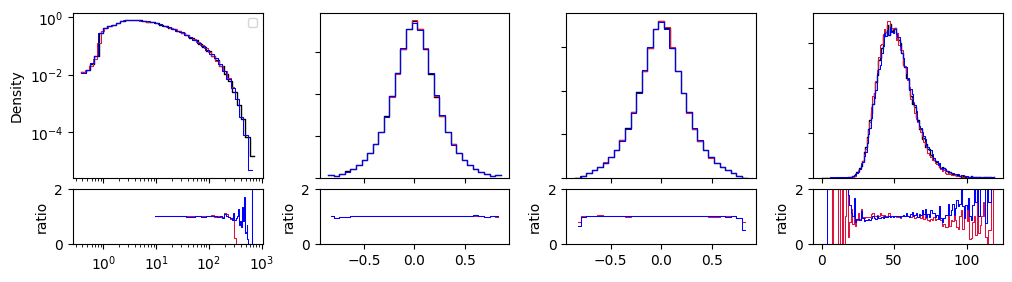

(<Figure size 1200x300 with 8 Axes>,
 array([<Axes: ylabel='Density'>, <Axes: >, <Axes: >, <Axes: >],
       dtype=object),
 array([<Axes: ylabel='ratio'>, <Axes: ylabel='ratio'>,
        <Axes: ylabel='ratio'>, <Axes: ylabel='ratio'>], dtype=object))

In [3]:
plot_with_ratio(tops_test_bins, tops_gen_bins, tops_aachen_bins)


/tmp/ipykernel_3848132/435882668.py:85: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_t.legend(fontsize=legend_fontsize)


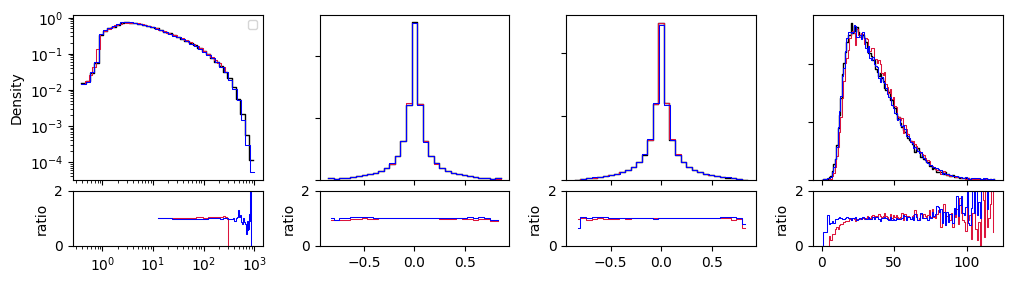

(<Figure size 1200x300 with 8 Axes>,
 array([<Axes: ylabel='Density'>, <Axes: >, <Axes: >, <Axes: >],
       dtype=object),
 array([<Axes: ylabel='ratio'>, <Axes: ylabel='ratio'>,
        <Axes: ylabel='ratio'>, <Axes: ylabel='ratio'>], dtype=object))

In [4]:
plot_with_ratio(qcd_test_bins, qcd_gen_bins, qcd_aachen_bins)


/tmp/ipykernel_3717822/2437477224.py:85: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_t.legend(fontsize=legend_fontsize)


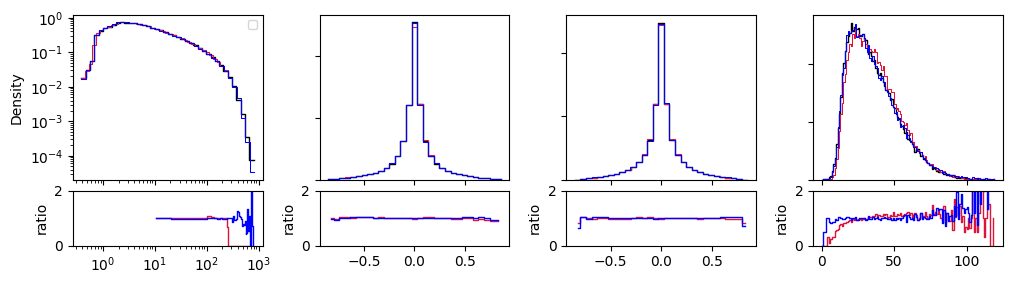

(<Figure size 1200x300 with 8 Axes>,
 array([<Axes: ylabel='Density'>, <Axes: >, <Axes: >, <Axes: >],
       dtype=object),
 array([<Axes: ylabel='ratio'>, <Axes: ylabel='ratio'>,
        <Axes: ylabel='ratio'>, <Axes: ylabel='ratio'>], dtype=object))

In [6]:
plot_with_ratio(qcd_test_bins, qcd_gen_bins, qcd_aachen_bins)


In [5]:
def jets_HL_feats(sample):
    pt = sample[..., 0]
    eta = sample[..., 1]
    phi = sample[..., 2]

    # px,py,pz:
    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    E = pt * np.cosh(eta)

    jet_4mom = np.stack([px, py, pz, E], axis=-1)
    jet_4mom = jet_4mom.sum(axis=1)


    # Calculate the invariant mass of the jets
    jet_pt = np.sqrt(jet_4mom[..., 0]**2 + jet_4mom[..., 1]**2)
    jet_eta = np.arcsinh(jet_4mom[..., 2] / jet_pt)
    jet_phi = np.arctan2(jet_4mom[..., 1], jet_4mom[..., 0])
    jet_mass = np.sqrt(np.maximum(0, jet_4mom[..., 3]**2 - (jet_4mom[..., 0]**2 + jet_4mom[..., 1]**2 + jet_4mom[..., 2]**2)))

    return np.stack([jet_pt, jet_eta, jet_phi, jet_mass], axis=-1)



     

In [6]:
from utils import JetSubstructure

tops_HL_test = jets_HL_feats(tops_test_bins)
qcd_HL_test = jets_HL_feats(qcd_test_bins)
tops_HL_gen = jets_HL_feats(tops_gen_bins)
qcd_HL_gen = jets_HL_feats(qcd_gen_bins)
# tops_HL_gen_ = jets_HL_feats(tops_gen_bins_)
# qcd_HL_gen_ = jets_HL_feats(qcd_gen_bins_)
tops_HL_aachen = jets_HL_feats(tops_aachen_bins)
qcd_HL_aachen = jets_HL_feats(qcd_aachen_bins)

In [7]:
from utils import JetSubstructure

tops_sub = JetSubstructure(tops_test_bins)
qcd_sub = JetSubstructure(qcd_test_bins)
tops_gen_sub = JetSubstructure(tops_gen_bins)
qcd_gen_sub = JetSubstructure(qcd_gen_bins)
# tops_gen_sub_ = JetSubstructure(tops_gen_bins_)
# qcd_gen_sub_ = JetSubstructure(qcd_gen_bins_)
tops_aachen_sub = JetSubstructure(tops_aachen_bins)
qcd_aachen_sub = JetSubstructure(qcd_aachen_bins)

Clustering jets with fastjet
Jet definition: Longitudinally invariant kt algorithm with R = 0.8 and pt-ordered Winner-Takes-All recombination
Calculating N-subjettiness
#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPY

Clustering jets with fastjet
Jet definition: Longitudinally invariant kt algorithm with R = 0.8 and pt-ordered Winner-Takes-All recombination
Calculating N-subjettiness
Clustering jets with fastjet
Jet definition: Longitudinally invariant kt algorithm with R = 0.8 and pt-ordered Winner-Takes-All recombination
Calculating N-subjettiness
Clustering jets with fastjet
Jet definition: Longitudinally invariant kt algorithm with R = 0.8 and pt-ordered Winner-Takes-All recombination
Calculating N-subjettiness
Clustering jets with fastjet
Jet definition: Longitudinally invariant kt algorithm with R = 0.8 and pt-ordered Winner-Takes-All recombination
Calculating N-subjettiness
Clustering jets with fastjet
Jet definition: Longitudinally invariant kt algorithm with R = 0.8 and pt-ordered Winner-Takes-All recombination
Calculating N-subjettiness


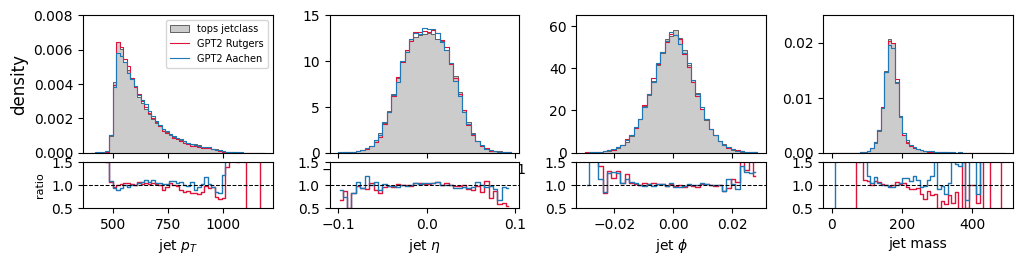

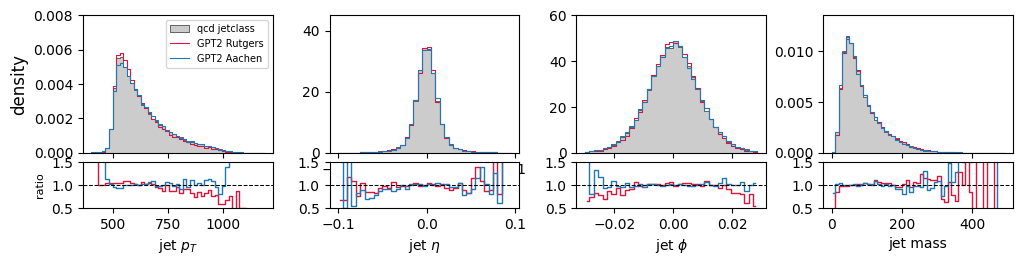

In [11]:
from utils import plot_hl_with_ratio, plot_substructure_with_ratio

bins0 = np.arange(400, 1200, 16)      # pT
bins1 = np.arange(-0.1, 0.1, 0.005) # eta
bins2 = np.arange(-0.03, 0.03, 0.0015)  # phi
bins3 = np.arange(0., 500, 10)    

bins = [bins0, bins1, bins2, bins3]

plot_hl_with_ratio(tops_HL_test, tops_HL_gen, tops_HL_aachen, bins, ylims=(0.008, 15, 65, 0.025), jet='tops jetclass')
# plot_hl_with_ratio(tops_HL_test, tops_HL_gen_, tops_HL_aachen, bins, ylims=(0.008, 15, 65, 0.025), jet='tops jetclass')

plot_hl_with_ratio(qcd_HL_test, qcd_HL_gen, qcd_HL_aachen, bins, ylims=(0.008, 45, 60, 0.0135), jet='qcd jetclass')
# plot_hl_with_ratio(qcd_HL_test, qcd_HL_gen_, qcd_HL_aachen, bins, ylims=(0.008, 45, 60, 0.0135), jet='qcd jetclass')


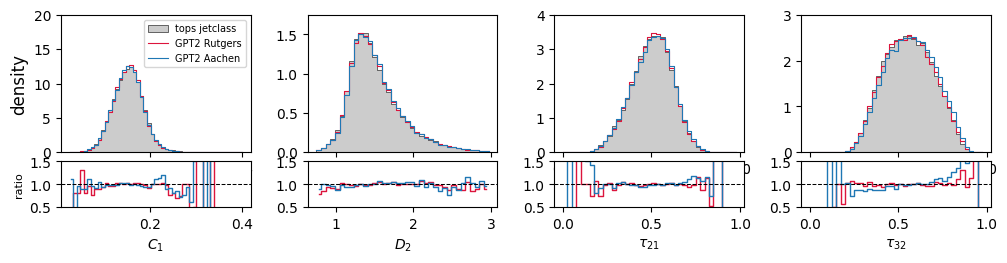

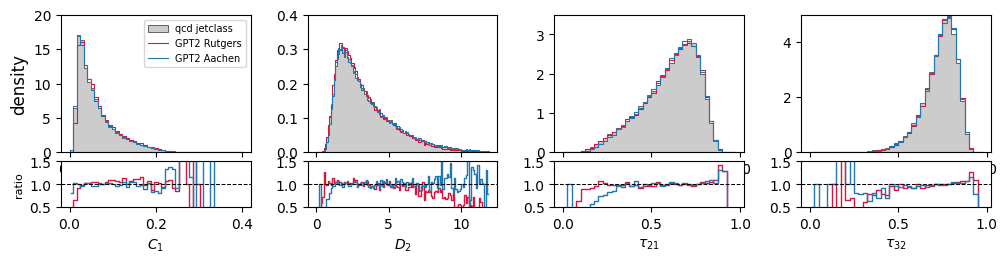

In [10]:
   

bins = [np.linspace(0.025, 0.4, 50), np.arange(0.75, 3, 0.06) , np.arange(0, 1, 0.025) , np.arange(0, 1, 0.025)]
plot_substructure_with_ratio(tops_sub, tops_gen_sub, tops_aachen_sub, bins, ylims=(17, 1.75, 4, 3),  jet='tops jetclass')

bins = [np.linspace(0, 0.4, 50), np.arange(0, 12, 0.25) , np.arange(0, 1, 0.025) , np.arange(0, 1, 0.025)]
plot_substructure_with_ratio(qcd_sub, qcd_gen_sub, qcd_aachen_sub, bins,  ylims=(20, 0.4, 3.5, 6),  jet='qcd jetclass')


### Check for ordering flips 

In [ ]:
k=0
flip_idx = []
for j, jet in enumerate(qcd_gen_bins):
    n = len(jet)
    for i, c in enumerate(jet):
        if i > 0:
            if jet[i,0] > jet[i-1, 0]:
                k+=1
                flip_idx.append(i)
                print(j, i)
                break


175 31
420 2
663 2
908 42
1092 1
1268 3
1400 23
1478 35
1505 21
1587 4
1591 27
1613 23
1651 43
1782 22
1852 20
2072 31
2164 34
2237 23
2453 14
2519 73
2801 6
2858 10
3047 4
3055 19
3069 1
3138 6
3257 13
3334 34
3381 10
3549 19
3647 6
3752 38
3894 4
3951 3
4015 1
4241 6
4453 25
4534 3
4535 7
4721 18
4858 39
4922 50
4955 32
4981 5
5019 3
5115 3
5525 12
5854 2
5900 9
5961 48
6095 33
6192 20
6246 4
6319 46
6411 33
6427 5
6485 33
6486 23
6873 7
6939 12
7126 46
7374 43
7418 14
7622 33
7632 2
7647 8
8036 25
8115 19
8390 49
8548 44
8559 1
8574 46
8788 29
8997 13
9069 14
9158 28
9481 23
9482 34
9593 44
9710 6
9791 5
9805 2
10018 22
10049 40
10082 11
10132 19
10280 2
10424 12
10685 2
10757 5
10769 65
10818 19
10946 11
11126 11
11172 25
11178 59
11305 29
11370 1
11618 22
11641 2
11669 3
11692 25
11799 49
11800 13
11965 59
12085 5
12185 44
12324 28
12456 16
12483 1
12712 22
12885 11
13032 28
13209 63
13321 4
13367 12
13398 3
13598 22
13615 29
13694 30
13840 5
14017 13
14386 26
14636 31
14760 9
149

freq flips:  0.00888


<Axes: ylabel='Density'>

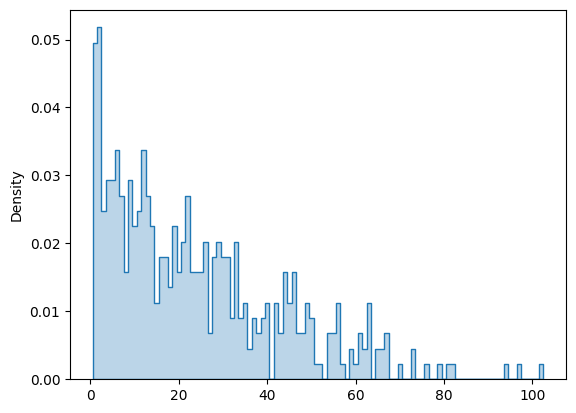

In [ ]:
print('freq flips: ', len(flip_idx) / N)
sns.histplot(flip_idx, discrete=True, fill=True, alpha=0.3, label='gpt2', element='step', stat='density',)

In [ ]:
k=0
flip_idx = []
for j, jet in enumerate(tops_gen_bins):
    n = len(jet)
    for i, c in enumerate(jet):
        if i > 0:
            if jet[i,0] > jet[i-1, 0]:
                k+=1
                flip_idx.append(i)
                print(j, i)
                break

42 50
152 2
239 40
343 29
431 25
450 4
515 39
638 19
670 3
766 46
797 33
820 44
828 53
884 18
969 33
1060 27
1196 37
1302 9
1435 12
1530 1
1623 35
1829 14
1958 40
1967 13
1974 58
1980 5
1998 13
2099 48
2153 54
2190 62
2252 7
2253 55
2326 15
2399 15
2546 4
2566 13
2600 65
2612 1
2639 30
2674 2
2692 9
2719 14
2776 14
2881 3
2891 6
2967 43
3021 12
3105 35
3148 65
3173 18
3204 37
3209 1
3215 13
3318 5
3406 7
3448 25
3625 23
3674 1
3724 4
3739 43
3794 11
3823 45
3836 11
3979 5
4007 2
4011 35
4025 71
4090 25
4149 20
4170 38
4328 24
4358 5
4439 52
4588 65
4612 45
4669 8
4680 7
4687 31
4695 13
4852 9
4868 22
4921 15
4932 25
4982 51
5068 4
5094 7
5381 75
5390 8
5493 35
5554 11
5555 1
5580 41
5612 21
5624 6
5653 40
5662 39
5761 31
5772 20
5778 2
5799 18
5883 13
5902 47
6356 15
6374 15
6449 45
6453 27
6568 23
6635 16
6663 6
6787 36
6942 4
6956 37
6964 2
6998 57
7090 44
7195 12
7210 44
7422 63
7463 3
7478 15
7543 23
7637 28
7777 3
7800 5
7809 9
7907 18
7909 33
7926 60
7941 3
7968 6
8078 1
8109 2
8

freq flips:  0.0163


<Axes: ylabel='Density'>

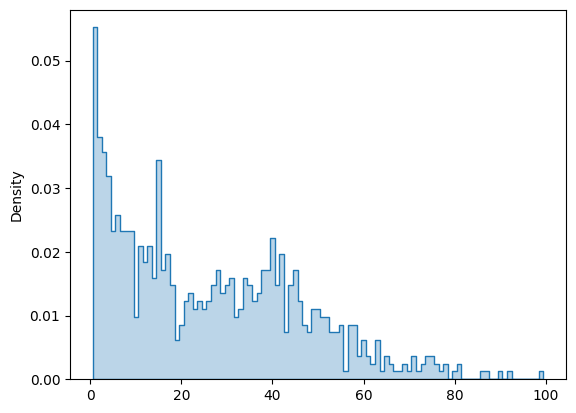

In [ ]:
print('freq flips: ', len(flip_idx) / N)
sns.histplot(flip_idx, discrete=True, fill=True, alpha=0.3, label='gpt2', element='step', stat='density',)

In [ ]:
# open yaml file

import yaml

def read_yaml_file(file_path):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print(f"Error reading YAML file: {e}")
            return None

bin_edges = read_yaml_file('bin_edges.yaml')


## Log-p computation

In [12]:
# tops_gpt2_ = JetGPT2Model.load_from_checkpoint(f"{path}/e66587b2c59b4773a97aa4afabd9b095/checkpoints/best.ckpt")
# tops_gpt2_.top_k = 5000 #tops_gpt2.start_token # remove top_k default cut
# tops_gpt2_.to("cuda:3")

# qcd_gpt2_ = JetGPT2Model.load_from_checkpoint(f"{path}/bfd0ed551863419a8a30e04b5a2fbae6/checkpoints/best.ckpt")
# qcd_gpt2_.top_k = 5000 #qcd_gpt2.start_token # remove top_k default cut
# qcd_gpt2_.to("cuda:2")

tops_gpt2 = JetGPT2Model.load_from_checkpoint(f"{path}/{sig_id}/checkpoints/best.ckpt")
tops_gpt2.top_k = 5000 #tops_gpt2.start_token # remove top_k default cut
tops_gpt2.to("cuda:1")

qcd_gpt2 = JetGPT2Model.load_from_checkpoint(f"{path}/{bkg_id}/checkpoints/best.ckpt")
qcd_gpt2.top_k = 5000 #qcd_gpt2.start_token # remove top_k default cut
qcd_gpt2.to("cuda:0")

Lightning automatically upgraded your loaded checkpoint from v1.9.5 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint experiments/results/comet/tokenized-jets/17eab02a204343a3969183034847009d/checkpoints/best.ckpt`
Lightning automatically upgraded your loaded checkpoint from v1.9.5 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint experiments/results/comet/tokenized-jets/301a89ea04ba46f59c2f39f34ff5f9b9/checkpoints/best.ckpt`


JetGPT2Model(
  (model): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(39405, 256)
      (wpe): Embedding(201, 256)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-7): 8 x GPT2Block(
          (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2SdpaAttention(
            (c_attn): Conv1D(nf=768, nx=256)
            (c_proj): Conv1D(nf=256, nx=256)
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D(nf=1024, nx=256)
            (c_proj): Conv1D(nf=256, nx=1024)
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_features=256, out_features

### logp's on gen data

In [13]:
#...ROC curve

tops_logp_on_qcd = tops_gpt2.log_probs(qcd_gen_seq, batch_size=32, device=tops_gpt2.device)
tops_logp_on_tops = tops_gpt2.log_probs(tops_gen_seq, batch_size=32, device=tops_gpt2.device)
qcd_logp_on_qcd = qcd_gpt2.log_probs(qcd_gen_seq, batch_size=32, device=qcd_gpt2.device)
qcd_logp_on_tops = qcd_gpt2.log_probs(tops_gen_seq, batch_size=32, device=qcd_gpt2.device)

LLR_tops = tops_logp_on_tops - qcd_logp_on_tops    
LLR_qcd = tops_logp_on_qcd - qcd_logp_on_qcd   


# tops_logp_on_qcd_ = tops_gpt2_.log_probs(qcd_gen_seq_, batch_size=32, device=tops_gpt2_.device)
# tops_logp_on_tops_ = tops_gpt2_.log_probs(tops_gen_seq_, batch_size=32, device=tops_gpt2_.device)
# qcd_logp_on_qcd_ = qcd_gpt2_.log_probs(qcd_gen_seq_, batch_size=32, device=qcd_gpt2_.device)
# qcd_logp_on_tops_ = qcd_gpt2_.log_probs(tops_gen_seq_, batch_size=32, device=qcd_gpt2_.device)

# LLR_tops_ = tops_logp_on_tops_ - qcd_logp_on_tops_    
# LLR_qcd_ = tops_logp_on_qcd_ - qcd_logp_on_qcd_  

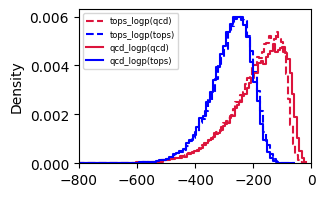

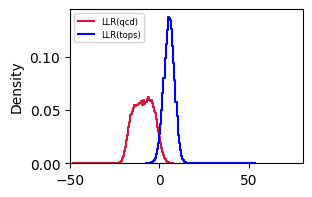

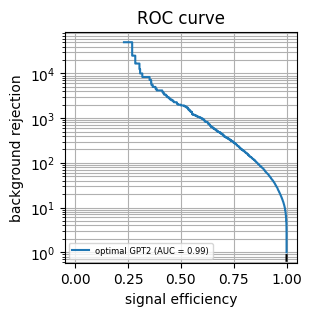

In [14]:
from utils  import ROC
import seaborn as sns

log = False
plt.figure(figsize=(3, 2))

sns.histplot(tops_logp_on_qcd, bins=100, ls='--', fill=False,label='tops_logp(qcd)', element='step', stat='density', color='crimson', log_scale=(False, log))
sns.histplot(tops_logp_on_tops, bins=100, ls='--',fill=False, label='tops_logp(tops)', element='step', stat='density', color='blue', log_scale=(False, log))
sns.histplot(qcd_logp_on_qcd, bins=100, fill=False,  label='qcd_logp(qcd)', element='step', stat='density', color='crimson', log_scale=(False, log))
sns.histplot(qcd_logp_on_tops, bins=100, fill=False,  label='qcd_logp(tops)', element='step', stat='density', color='blue', log_scale=(False, log))
plt.legend(fontsize=6, loc="upper left")
plt.xlim(-800, 0)

plt.figure(figsize=(3, 2))

sns.histplot(LLR_qcd, bins=100, fill=False,label='LLR(qcd)', element='step', stat='density', color='crimson', log_scale=(False, log))
sns.histplot(LLR_tops, bins=100,fill=False, label='LLR(tops)', element='step', stat='density', color='blue', log_scale=(False, log))
plt.legend(fontsize=6, loc="upper left")
plt.xlim(-50, 80)

plt.figure(figsize=(3, 3))
ROC(LLR_qcd, LLR_tops, "optimal GPT2")
plt.grid(True,which='both')
plt.legend(fontsize=6, loc="lower left")


In [3]:
LLR_tops

NameError: name 'LLR_tops' is not defined

### logp's on test data

In [ ]:
tops_logp_on_qcd = tops_gpt2.log_probs(qcd_test_seq, batch_size=32, device=tops_gpt2.device)
tops_logp_on_tops = tops_gpt2.log_probs(tops_test_seq, batch_size=32, device=tops_gpt2.device)
qcd_logp_on_qcd = qcd_gpt2.log_probs(qcd_test_seq, batch_size=32, device=qcd_gpt2.device)
qcd_logp_on_tops = qcd_gpt2.log_probs(tops_test_seq, batch_size=32, device=qcd_gpt2.device)

/home/df630/SyntheticJets/utils.py:17: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr, 1 / fpr, label=f"{label} (AUC = {roc_auc:.2f})")


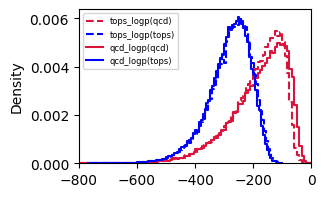

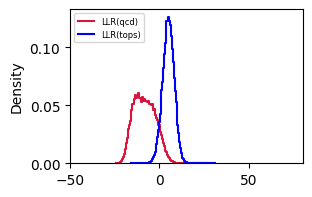

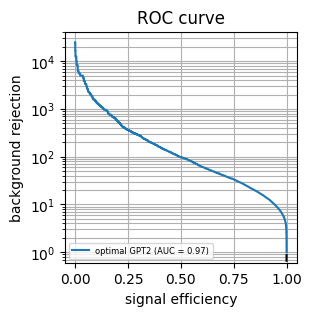

In [ ]:
from utils  import ROC
import seaborn as sns

log = False
plt.figure(figsize=(3, 2))

sns.histplot(tops_logp_on_qcd, bins=100, ls='--', fill=False,label='tops_logp(qcd)', element='step', stat='density', color='crimson', log_scale=(False, log))
sns.histplot(tops_logp_on_tops, bins=100, ls='--',fill=False, label='tops_logp(tops)', element='step', stat='density', color='blue', log_scale=(False, log))
sns.histplot(qcd_logp_on_qcd, bins=100, fill=False,  label='qcd_logp(qcd)', element='step', stat='density', color='crimson', log_scale=(False, log))
sns.histplot(qcd_logp_on_tops, bins=100, fill=False,  label='qcd_logp(tops)', element='step', stat='density', color='blue', log_scale=(False, log))
plt.legend(fontsize=6, loc="upper left")
plt.xlim(-800, 0)

LLR_tops = tops_logp_on_tops - qcd_logp_on_tops    
LLR_qcd = tops_logp_on_qcd - qcd_logp_on_qcd   

plt.figure(figsize=(3, 2))

sns.histplot(LLR_qcd, bins=100, fill=False,label='LLR(qcd)', element='step', stat='density', color='crimson', log_scale=(False, log))
sns.histplot(LLR_tops, bins=100,fill=False, label='LLR(tops)', element='step', stat='density', color='blue', log_scale=(False, log))
plt.legend(fontsize=6, loc="upper left")
plt.xlim(-50, 80)


plt.figure(figsize=(3, 3))
ROC(LLR_qcd, LLR_tops, "optimal GPT2")
plt.grid(True,which='both')
plt.legend(fontsize=6, loc="lower left")